<a href="https://colab.research.google.com/github/rahiakela/deep-learning-for-computer-vision/blob/main/1-image-data-preparation/2_manually_scale_image_pixel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Manually Scale Image Pixel Data

Images are comprised of matrices of pixel values. Black and white images are single matrix of pixels, whereas color images have a separate array of pixel values for each color channel, such as red, green, and blue. Pixel values are often unsigned integers in the range between 0 and 255. Although these pixel values can be presented directly to neural network models in their raw format, this can result in challenges during modeling, such as in slower than expected training of the model.

Instead, there can be great benefit in preparing the image pixel values prior to modeling, such as simply scaling pixel values to the range 0-1 to centering and even standardizing the values.

## Load image

Let's load the image, display some properties about the loaded image,
then show the image.

In [ ]:
!wget https://machinelearningmastery.com/wp-content/uploads/2019/01/The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png

In [11]:
from PIL import Image
from numpy import asarray
from numpy import clip

In [3]:
# load the image
image = Image.open("The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png")

# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)

PNG
P
(1280, 856)


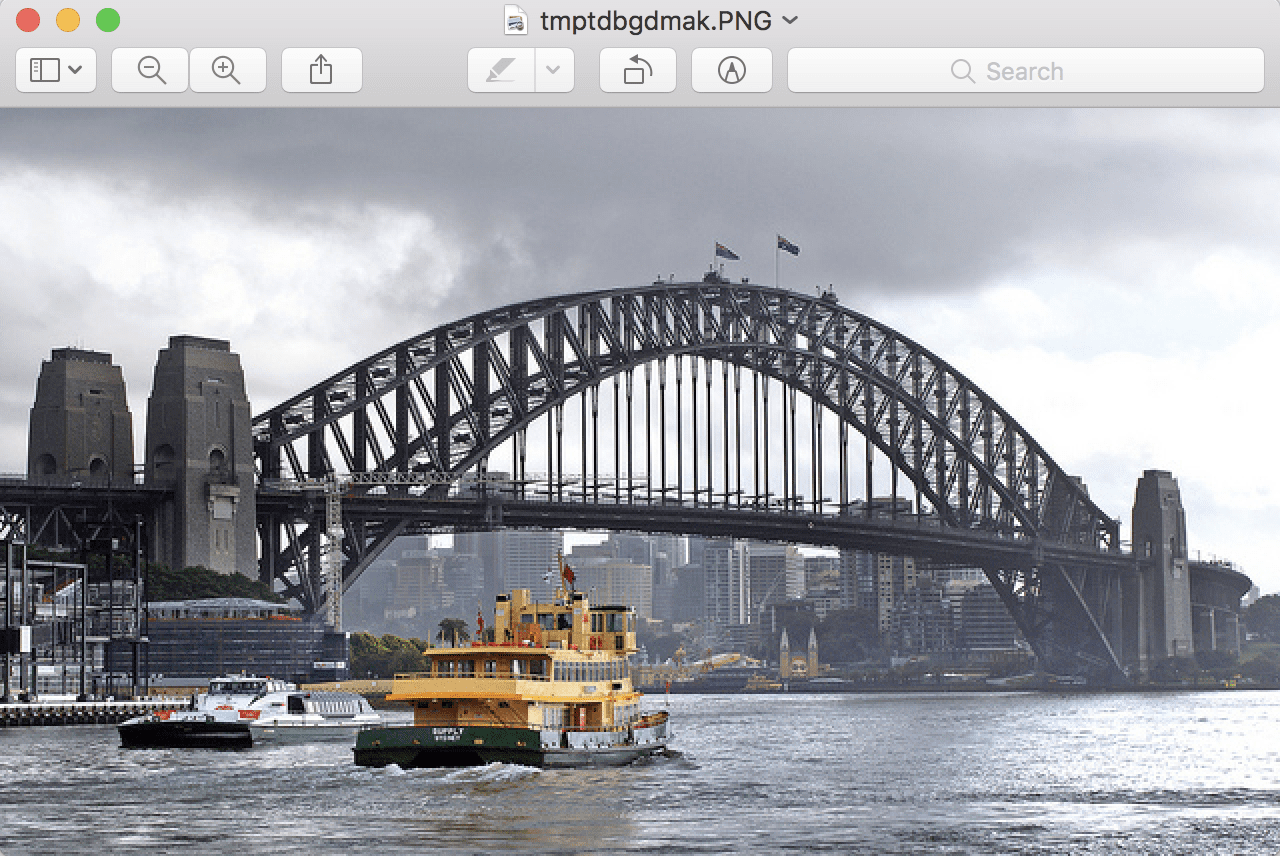

In [4]:
# show the image
image

## Normalize Pixel Values

For most image data, the pixel values are integers with values between 0 and 255. Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. It is valid for images to have pixel values in the range 0-1 and images can be viewed normally.

This can be achieved by dividing all pixels values by the largest pixel value; that is 255. This is performed across all channels, regardless of the actual range of pixel values that are present in the image.

In [ ]:
pixels = asarray(image)

# confirm pixel range is 0-255
print("Data Type: %s" % pixels.dtype)
print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))

# convert from integers to floats
pixels = pixels.astype("float32")

# normalize to the range 0-1
pixels /= 158.0

# confirm the normalization
print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 0.000, Max: 158.000
Min: 0.000, Max: 1.000


Normalization is a good default data preparation that can be performed if you are in doubt as to the type of data preparation to perform. It can be performed per image and does not require the calculation of statistics across the training dataset, as the range of pixel values is a domain standard.

##Center Pixel Values

A popular data preparation technique for image data is to subtract the mean value from the pixel values. This approach is called centering, as the distribution of the pixel values is centered on the value of zero. Centering can be performed before or after normalization. Centering the pixels then normalizing will mean that the pixel values will be centered close to 0.5 and be in the range 0-1. Centering after normalization will mean that the pixels will have positive and negative values, in which case images will not display correctly (e.g. pixels are expected to have value in the range 0-255 or 0-1). Centering after normalization might be preferred, although it might be worth testing both approaches.

Centering requires that a mean pixel value be calculated prior to subtracting it from the pixel values. There are multiple ways that the mean can be calculated; for example:

- Per image.
- Per minibatch of images (under stochastic gradient descent).
- Per training dataset.

The mean can be calculated for all pixels in the image, referred to as a global centering, or it can be calculated for each channel in the case of color images, referred to as local centering.

- **Global Centering**: Calculating and subtracting the mean pixel value across color channels.
- **Local Centering**: Calculating and subtracting the mean pixel value per color channel.

Per-image global centering is common because it is trivial to implement. Also common is per minibatch global or local centering for the same reason: it is fast and easy to implement.

In some cases, per-channel means are pre-calculated across an entire training dataset. In this case, the image means must be stored and used both during training and any inference with the trained models in the future. For models trained on images centered using these means that may be used for transfer learning on new tasks, it can be beneficial or even required to normalize images for the new task using the same means.

### Global Centering

In [ ]:
# load the image
image = Image.open("The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png")
pixels = asarray(image)

# convert from integers to floats
pixels = pixels.astype("float32")

# calculate global mean
mean = pixels.mean()
print("Mean: %s" % mean)
print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))

# global centering of pixels
pixels = pixels - mean
mean = pixels.mean()

# confirm it had the desired effect
print("Mean: %s" % mean)
print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))

Mean: 49.570564
Min: 0.000, Max: 158.000
Mean: 9.469006e-06
Min: -49.571, Max: 108.429


Once centered, we can confirm that the new mean for the pixel values is 0.0 and that the new data range is negative and positive around this mean.

### Local Centering

Let's calculates the mean for each color channel in the loaded image, then
centers the pixel values for each channel separately. Note that NumPy allows us to specify the dimensions over which a statistic like the mean, min, and max are calculated via the axis argument.

In [ ]:
# load the image
image = Image.open("The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png")
pixels = asarray(image)

# convert from integers to floats
pixels = pixels.astype("float32")

# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0, 1), dtype="float64")
print("Mean: %s" % means)
print("Min: %.3f, Max: %.3f" % (pixels.min(axis=(0, 1)), pixels.max(axis=(0, 1))))

#per-channel centering of pixels
pixels -= means
mean = pixels.mean(axis=(0, 1), dtype="float64")

# confirm it had the desired effect
print("Mean: %s" % means)
print("Min: %.3f, Max: %.3f" % (pixels.min(axis=(0, 1)), pixels.max(axis=(0, 1))))

Mean: 49.57056713639019
Min: 0.000, Max: 158.000
Mean: 49.57056713639019
Min: -49.571, Max: 108.429


## Standardize Pixel Values

The distribution of pixel values often follows a Normal or Gaussian distribution, e.g. bell shape. This distribution may be present per image, per minibatch of images, or across the training dataset and globally or per channel. 

As such, there may be benefit in transforming the distribution of pixel values to be a standard Gaussian: that is both centering the pixel values on zero and normalizing the values by the standard deviation. The result is a standard Gaussian of pixel values with a mean of 0.0 and a standard deviation of 1.0.

Standardization may be preferred to normalization and centering alone and it results in both zero-centered values and small input values, roughly in the range -3 to 3, depending on the specifics of the dataset. For consistency of the input data, it may make more sense to standardize images per-channel using statistics calculated per minibatch or across the training dataset, if possible.

### Global Standardization

Let's calculates the mean and standard deviations across all color channels in the loaded image, then uses these values to standardize the pixel values.

In [10]:
# load the image
image = Image.open("The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png")
pixels = asarray(image)

# convert from integers to floats
pixels = pixels.astype("float32")

# calculate global mean and standard deviation
means, std = pixels.mean(), pixels.std()
print("Mean: %.3f, Standard Deviation: %.3f" % (means, std))

# global standardization of pixels
pixels = (pixels - means) / std

# confirm it had the desired effect
means, std = pixels.mean(), pixels.std()
print("Mean: %.3f, Standard Deviation: %.3f" % (means, std))

Mean: 49.571, Standard Deviation: 37.351
Mean: 0.000, Standard Deviation: 1.000


### Positive Global Standardization

There may be a desire to maintain the pixel values in the positive domain, perhaps so the images can be visualized or perhaps for the benefit of a chosen activation function in the model. A popular way of achieving this is to clip the standardized pixel values to the range `[-1, 1]` and then rescale the values from `[-1,1] to [0,1]`.

In [14]:
# load the image
image = Image.open("The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png")
pixels = asarray(image)

# convert from integers to floats
pixels = pixels.astype("float32")

# calculate global mean and standard deviation
means, std = pixels.mean(), pixels.std()
print("Mean: %.3f, Standard Deviation: %.3f" % (means, std))

# global standardization of pixels
pixels = (pixels - means) / std

# clip pixel values to [-1,1]
pixels = clip(pixels, -1.0, 1.0)

# shift from [-1,1] to [0,1] with 0.5 mean
pixels = (pixels + 1.0) / 2.0

# confirm it had the desired effect
means, std = pixels.mean(), pixels.std()
print("Mean: %.3f, Standard Deviation: %.3f" % (means, std))
print("Min: %.3f, Max: %.3f" % (pixels.min(), pixels.max()))

Mean: 49.571, Standard Deviation: 37.351
Mean: 0.459, Standard Deviation: 0.380
Min: 0.000, Max: 1.000


### Local Standardization

Let's calculates the mean and standard deviation of the loaded image per-channel, then uses these statistics to standardize the pixels separately in each channel.

In [16]:
# load the image
image = Image.open("The-Sydney-Harbor-Bridge-Photograph-Loaded-From-File.png")
pixels = asarray(image)

# convert from integers to floats
pixels = pixels.astype("float32")

# calculate per-channel means and standard deviations
means = pixels.mean(axis=(1, 0), dtype="float64")
stds = pixels.std(axis=(1, 0), dtype="float64")
print("Mean: %.3f, Standard Deviation: %.3f" % (means, stds))

# per-channel standardization of pixels
pixels = (pixels - means) / stds

# confirm it had the desired effect
means = pixels.mean(axis=(1, 0), dtype="float64")
stds = pixels.std(axis=(1, 0), dtype="float64")
print("Mean: %.3f, Standard Deviation: %.3f" % (means, stds))

Mean: 49.571, Standard Deviation: 37.351
Mean: -0.000, Standard Deviation: 1.000
